In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import shutil
import zipfile

In [3]:
! chmod 600 /content/kaggle.json

In [4]:
!KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d utkarshsaxenadn/fast-food-classification-dataset

 99% 811M/821M [00:08<00:00, 201MB/s]
100% 821M/821M [00:08<00:00, 105MB/s]


In [9]:
zip_file = zipfile.ZipFile('/content/fast-food-classification-dataset.zip', 'r')
zip_file.extractall('/tmp/')

In [10]:
original_dataset_dir = '/tmp/Fast Food Classification V2/Train'

# Path to create train and test directories
base_dir = 'path/to/base_dir'
os.makedirs(base_dir, exist_ok=True)

# Creating train and test directories
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# List of class directories in the original dataset
class_directories = os.listdir(original_dataset_dir)


In [11]:
for class_dir in class_directories:
    class_path = os.path.join(original_dataset_dir, class_dir)

    # Split the images into 80% train and 20% test
    train_class_path, test_class_path = train_test_split(os.listdir(class_path), test_size=0.2, random_state=42)

    # Create train class directory
    train_class_dir = os.path.join(train_dir, class_dir)
    os.makedirs(train_class_dir, exist_ok=True)

    # Create test class directory
    test_class_dir = os.path.join(test_dir, class_dir)
    os.makedirs(test_class_dir, exist_ok=True)

    # Copy images to train class directory
    for img in train_class_path:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_class_dir, img))

    # Copy images to test class directory
    for img in test_class_path:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_class_dir, img))


In [12]:
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

In [13]:
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [14]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest',
                                   horizontal_flip=True)

# Rescaling for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating data generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=32,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=32,
                                                  class_mode='categorical')

Found 12000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


In [16]:
model = models.Sequential()

# Add the pre-trained base model
model.add(base_model)

# Add a Conv2D layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Add a Conv2D layer
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Add a Conv2D layer
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))

# Add GlobalAveragePooling2D layer
model.add(layers.GlobalAveragePooling2D())

# Add a Dense layer
model.add(layers.Dense(512, activation='relu'))

# Add the output layer
model.add(layers.Dense(10, activation='softmax'))  # Assuming 10 classes


In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [19]:
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92:
            print("\nTraining stopped as accuracy is above 92% on both training and validation sets.")
            self.model.stop_training = True

In [20]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)

In [21]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_generator.samples // train_generator.batch_size,
                              epochs=50,  # You can adjust the number of epochs
                              validation_data=test_generator,
                              validation_steps=test_generator.samples // test_generator.batch_size,
                              callbacks=[CustomCallback(), reduce_lr])

<ipython-input-21-13e62a292815>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/50
112/375 [=======>......................] - ETA: 1:44 - loss: 1.4179 - accuracy: 0.5195

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


375/375 [==============================] - 165s 420ms/step - loss: 1.1053 - accuracy: 0.6461 - val_loss: 0.7226 - val_accuracy: 0.7843 - lr: 0.0010
Epoch 2/50
375/375 [==============================] - 158s 421ms/step - loss: 0.8012 - accuracy: 0.7535 - val_loss: 0.6782 - val_accuracy: 0.7947 - lr: 0.0010
Epoch 3/50
375/375 [==============================] - 156s 417ms/step - loss: 0.7313 - accuracy: 0.7738 - val_loss: 0.6411 - val_accuracy: 0.8041 - lr: 0.0010
Epoch 4/50
375/375 [==============================] - 155s 413ms/step - loss: 0.6794 - accuracy: 0.7951 - val_loss: 0.5876 - val_accuracy: 0.8179 - lr: 0.0010
Epoch 5/50
375/375 [==============================] - 156s 416ms/step - loss: 0.6607 - accuracy: 0.7929 - val_loss: 0.6313 - val_accuracy: 0.8108 - lr: 0.0010
Epoch 6/50
375/375 [==============================] - 161s 429ms/step - loss: 0.6123 - accuracy: 0.8118 - val_loss: 0.6106 - val_accuracy: 0.8132 - lr: 0.0010
Epoch 7/50
375/375 [==============================] - 166

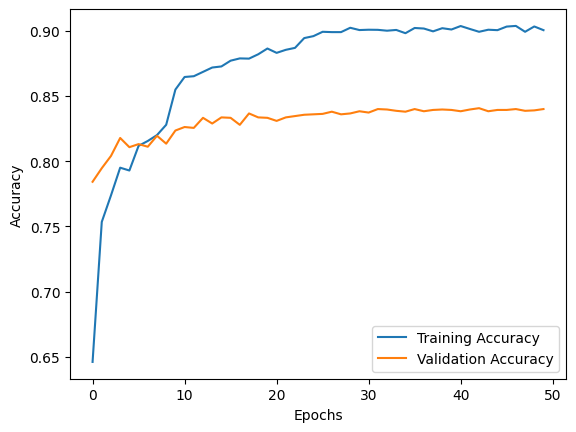

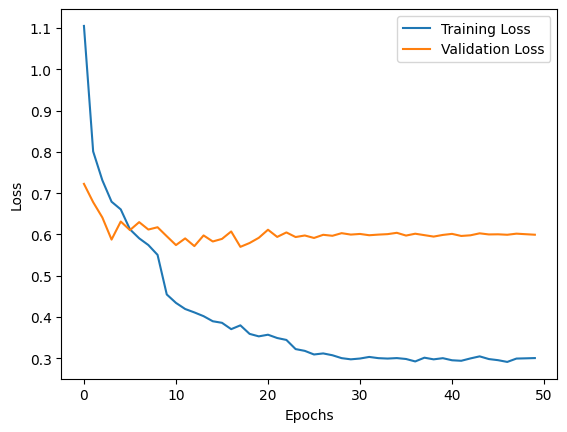

In [22]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
model.save('transfer_learning_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('transfer_learning_model.tflite', 'wb') as f:
    f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
